# Содержание

1. Цель и задачи проекта
2. Загрузка данных, ознакомление с ними и предобработка
   2.1 Подключение необходимых библиотек
   2.2 Получение данных таблицы посещений
   2.3 Предобработка (таблица посещений): проверка на наличие пропусков, дубликатов, переименрование столбцов, изменение типа данных
   2.4 Получение данных таблицы заказов
   2.5 Предобработка (таблица заказов): проверка на наличие пропусков, дубликатов, переименрование столбцов, изменение типа данных
   2.6 Получение данных таблицы расходов на рекламу
   2.7 Предобработка (таблица расходов на рекламу): проверка на наличие пропусков, дубликатов, изменение типа данных
   2.8 Вывод.
3. Узнаем на какой источник было потрачено больше всего средств за год
4. Зададим функции для расчета и анализа LTV
   4.1 Функция для создания пользовательских профилей
   4.2 Получим таблицу профилей, вызвав функцию get_profiles
   4.3 Напишем функцию для расчета LTV
5. Исследовательский анализ
   5.1 Выясним на какой источник приходится больше всего платящих пользователей.
   5.2 Определим с какого устройства приходит больше всего платящих пользователей
6. Найдем средний LTV пользователей, которые впервые пришли до декабря 2017 года
   6.1 Получение среза датафрейма в соответствии с датой
   6.2 Вызовем функцию get_ltv
   6.3 Найдем средний и суммарный показатель LTV
7. Определим какая когорта (по месяцам первого посещения) принесла больше всего денег за полгода жизни
   7.1 Посмотрим на показатели пользователей с лайфтаймом в пол года
   7.2 Визуализируем общий LTV в динамике за пол года
   7.3 Визуализируем LTV за пол года жизни в динамики по когортам первого посещения
8. Оценим распределение LTV по источнику привлечения и устройству
   8.1 Получим таблицы LTV с параметром dimensions на источник
   8.2 Визуализируем LTV в соответствии с источником привлечения пользователей
   8.3 Получим таблицы LTV, но уже с параметром dimensions на устройство
   8.4 Визуализируем LTV в соответствии с устройством пользователя
9. Вывод по проекту и рекомендации
10. Презентация

## 1. Цель и задачи проекта

У нас в распоряжении есть лог сервера с данными за год с июня 2017 по конец мая 2018 года: посещения сайта Яндекс.Афиши, выгрузка всех заказов за этот период, а также статистика рекламных расходов. Нам предстоит изучить, как люди пользуются продуктом, через какие каналы приходят, когда они начинают покупать, сколько денег приносит каждый клиент.
Задачи:
   - выяснить на какой источник было потрачено больше всего денег за год
   - вычислить средний LTV пользователей, которые впервые пришли до декабря 2017 года
   - найти какая кагорта (по месяцам первого посещения) принесла больше всего денег за полгода жизни
   - определить целевую аудиторию
   - сделать выводы и дать рекомендации

## 2. Загрузка данных, ознакомление с ними и предобработка

### 2.1 Подключение необходимых библиотек

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

### 2.2 Получение данных таблицы посещений

In [42]:
way = 'C:\\Users\\Anore\\Project sprints\\drweb\\'

In [43]:
df_visits = pd.read_csv(way + 'visits_log.csv')
display(df_visits.head(10))
df_visits.info()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


### 2.3 Предобработка (таблица посещений): проверка на наличие пропусков, дубликатов, переименрование столбцов, изменение типа данных

In [44]:
# проверим наличие дубликатов и пропусков
display(df_visits.duplicated().sum())
display(df_visits.isna().sum())

0

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [45]:
# приведение названий столбцов к корректному виду
df_visits = df_visits.rename(columns = {
    'Device': 'device',
    'End Ts': 'end_ts',
    'Source Id': 'source_id',
    'Start Ts': 'start_ts',
    'Uid': 'uid'
})
df_visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [46]:
# преобразование типов столбцов таблицы посещений к формату времени (datetime)
df_visits['end_ts'] = pd.to_datetime(df_visits['end_ts'])
df_visits['start_ts'] = pd.to_datetime(df_visits['start_ts'])
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


### 2.4 Получение данных таблицы заказов

In [47]:
df_orders = pd.read_csv(way + 'orders_log.csv')
display(df_orders.head(10))
df_orders.info()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


### 2.5 Предобработка (таблица заказов): проверка на наличие пропусков, дубликатов, переименрование столбцов, изменение типа данных

In [48]:
# проверим наличие дубликатов и пропусков
display(df_orders.duplicated().sum())
display(df_orders.isna().sum())

0

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

In [49]:
# приведение названий столбцов к корректному виду
df_orders = df_orders.rename(columns = {
    'Buy Ts': 'buy_ts',
    'Revenue': 'revenue',
    'Uid': 'uid'
})
df_orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [50]:
# преобразование типов столбцов к формату времени (datetime)
df_orders['buy_ts'] = pd.to_datetime(df_orders['buy_ts'])
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


### 2.6 Получение данных таблицы расходов на рекламу

In [51]:
df_costs = pd.read_csv(way + 'costs.csv')
display(df_costs.head(10))
df_costs.info()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


### 2.7 Предобработка (таблица расходов на рекламу): проверка на наличие пропусков, дубликатов, изменение типа данных

In [52]:
# проверим наличие дубликатов и пропусков
display(df_costs.duplicated().sum())
display(df_costs.isna().sum())

0

source_id    0
dt           0
costs        0
dtype: int64

In [53]:
# преобразование типов столбцов к формату времени (datetime)
df_costs['dt'] = pd.to_datetime(df_costs['dt'])
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### 2.8 Вывод

Были получены данные трех таблиц. Пропусков и дубликатов не было обнаружено. Столбцы дат были преобразованы в соответствующий тип данных, а названия столбцов приведены к нижнему регистру "змеиного" типа.

## 3. Узнаем на какой источник было потрачено больше всего средств за год

In [54]:
report_costs = df_costs.groupby('source_id').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False).reset_index()
display(report_costs)

,source_id,costs
0,3,141321.63
1,4,61073.60
2,5,51757.10
3,2,42806.04
4,1,20833.27
5,10,5822.49
6,9,5517.49


Больше всего средств было потрачено на 3-ий источник, почти в 2,5 раза больше чем на 4. На 9 и 10 источник потрачено примерно одинаковое количество средств и на порядок меньше чем на другие.

## 4. Зададим функции для расчета и анализа LTV

### 4.1 Функция для создания пользовательских профилей

Функция профилей, связующее звено, необходимое для создания полей по которым происходит расчет последующих функций.

In [55]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['uid', 'start_ts'])
        .groupby('uid')
        .agg(
            {
                'start_ts': 'first',
                'source_id': 'first',
                'device': 'first',
            }
        )
        .rename(columns={'start_ts': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['uid'].isin(orders['uid'].unique())

    return profiles

### 4.2 Получим таблицу профилей, вызвав функцию get_profiles

Для этого передадим три исходных датафрейма о посещениях, покупках и тратах на рекламу.

In [56]:
profiles = get_profiles(df_visits, df_orders, df_costs)
display(profiles.head())
profiles.info()
display(profiles.isna().sum())

,uid,first_ts,source_id,device,dt,month,payer
0,11863502262781,2018-03-01 17:27:00,3,touch,2018-03-01,2018-03-01,False
1,49537067089222,2018-02-06 15:55:00,2,touch,2018-02-06,2018-02-01,False
2,297729379853735,2017-06-07 18:47:00,3,desktop,2017-06-07,2017-06-01,False
3,313578113262317,2017-09-18 22:49:00,2,desktop,2017-09-18,2017-09-01,True
4,325320750514679,2017-09-30 14:29:00,5,desktop,2017-09-30,2017-09-01,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228169 entries, 0 to 228168
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   uid        228169 non-null  uint64        
 1   first_ts   228169 non-null  datetime64[ns]
 2   source_id  228169 non-null  int64         
 3   device     228169 non-null  object        
 4   dt         228169 non-null  object        
 5   month      228169 non-null  datetime64[ns]
 6   payer      228169 non-null  bool          
dtypes: bool(1), datetime64[ns](2), int64(1), object(2), uint64(1)
memory usage: 10.7+ MB


uid          0
first_ts     0
source_id    0
device       0
dt           0
month        0
payer        0
dtype: int64

### 4.3 Напишем функцию для расчета LTV

In [57]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о выручке в профили
    result_raw = profiles.merge(
        orders[['uid', 'buy_ts', 'revenue']],
        on='uid',
        how='left',
    )

    # вычисляем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['buy_ts'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',
            aggfunc='sum',
        )
        # считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'uid': 'nunique'})
            .rename(columns={'uid': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV:
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions,  horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

## 5. Исследовательский анализ

### 5.1 Выясним на какой источник приходится больше всего платящих пользователей

In [58]:
report_source = profiles.groupby('source_id').agg({'uid': 'nunique', 'payer': 'sum'}).sort_values(by='uid', ascending=False).reset_index()
report_source['доля платящих%'] = round(report_source['payer'] / report_source['uid'] * 100, 2)
report_source = report_source.rename(columns={
    'uid': 'количество пользователей',
    'payer': 'количество платящих пользователей'
})
display(report_source.head(10))

,source_id,количество пользователей,количество платящих пользователей,доля платящих%
0,4,72346,10296,14.23
1,3,66116,10473,15.84
2,5,49237,6931,14.08
3,2,17616,3506,19.90
4,1,9469,2899,30.62
5,10,6903,1329,19.25
6,9,6448,1088,16.87
7,7,32,1,3.12
8,6,2,0,0.00


Больше всего пользователей приходят из третьего источника, однако конверсия в платящих ниже чем у других. Самое высокое суммарное количество покупателей так же у третьего источника.

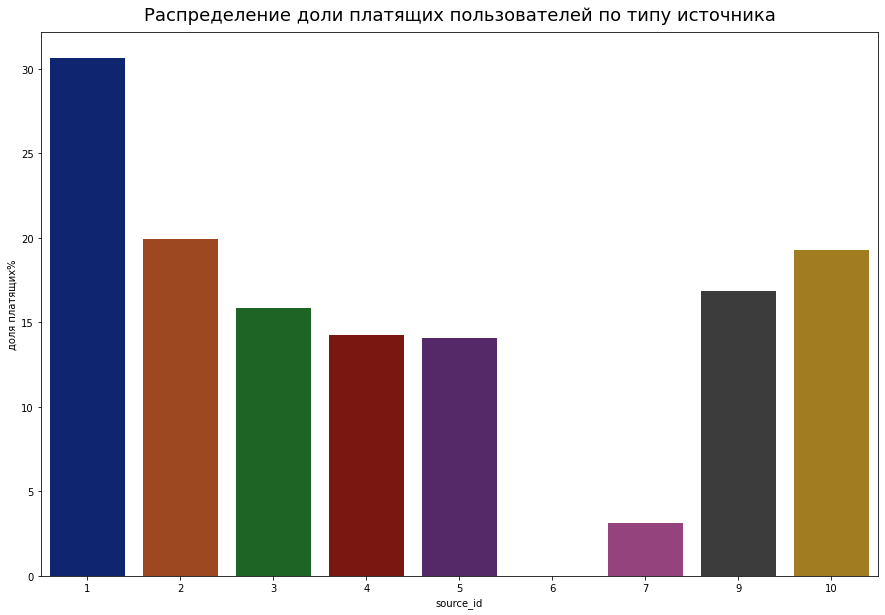

In [59]:
# используем столбчатую гистограмму библиотеки seaborn
plt.figure(figsize=(15,10))
ax = sns.barplot(x=report_source['source_id'], y=report_source['доля платящих%'])
sns.set_palette('dark')
ax.set_title('Распределение доли платящих пользователей по типу источника', fontdict={'fontsize':18}, pad=12)
plt.show()

Больше всего платящих пользователей приходят из первого источника. Источники номер 6 и 7 не получали бюджета, отсюда такие низкие показатели. 

### 5.2 Определим с какого устройства приходит больше всего платящих пользователей

In [60]:
report_device = profiles.groupby('device').agg({'uid': 'nunique', 'payer': 'sum'}).sort_values(by='uid', ascending=False).reset_index()
report_device['Доля платящих%'] = round(report_device['payer'] / report_device['uid'] * 100, 2)
report_device = report_device.rename(columns={
    'uid': 'количество пользователей',
    'payer': 'количество платящих пользователей'
})
display(report_device.head())

,device,количество пользователей,количество платящих пользователей,Доля платящих%
0,desktop,160795,29211,18.17
1,touch,67374,7312,10.85


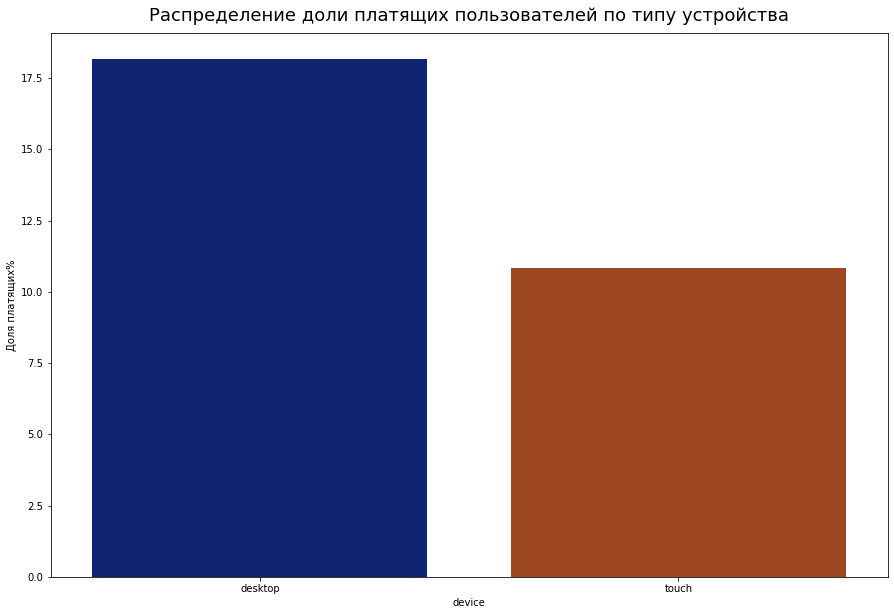

In [61]:
# используем столбчатую гистограмму библиотеки seaborn
plt.figure(figsize=(15,10))
ax = sns.barplot(x=report_device['device'], y=report_device['Доля платящих%'])
sns.set_palette('dark')
ax.set_title('Распределение доли платящих пользователей по типу устройства', fontdict={'fontsize':18}, pad=12)
plt.show()

Через компьютер приходит значительно больше пользователей примерно в 2.5 раза. Общее количество покупателей и их доля так же выше в сравнении с теми кто пользуется мобильным приложением.

## 6. Найдем средний LTV пользователей, которые впервые пришли до декабря 2017 года

### 6.1 Получение среза датафрейма в соответствии с датой

Нас интересуют только те пользователи, чей первый приход был до декабря 2017г. Уберем данные из таблицы профилей пользователей начиная с 1 декабря 2017 года.

In [62]:
profiles = profiles.loc[(profiles['month'] < '2017-12-01')]
display(profiles['month'].unique())
profiles.info()

array(['2017-06-01T00:00:00.000000000', '2017-09-01T00:00:00.000000000',
       '2017-10-01T00:00:00.000000000', '2017-11-01T00:00:00.000000000',
       '2017-07-01T00:00:00.000000000', '2017-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106509 entries, 2 to 228168
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   uid        106509 non-null  uint64        
 1   first_ts   106509 non-null  datetime64[ns]
 2   source_id  106509 non-null  int64         
 3   device     106509 non-null  object        
 4   dt         106509 non-null  object        
 5   month      106509 non-null  datetime64[ns]
 6   payer      106509 non-null  bool          
dtypes: bool(1), datetime64[ns](2), int64(1), object(2), uint64(1)
memory usage: 5.8+ MB


### 6.2 Вызовем функцию get_ltv 

Получим таблицу сырых данных, таблицу ltv по всем пользователям и интересующую нас сводную таблицу динамики ltv_history, где строки это дата первого прихода пользователя, а столбцы это лайфтайм с уже посчитанным показателем LTV.

In [63]:
ltv_raw, ltv, ltv_history = get_ltv(
    profiles, df_orders, datetime(2017, 11, 30).date(), 183)

ltv_history.tail().reset_index()

,dt,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,173.0,174.0,175.0,176.0,177.0,178.0,179.0,180.0,181.0,182.0
0,2017-11-26,872,0.349151,0.358073,0.403337,0.403337,0.408349,0.411433,0.412511,0.412787,...,0.604037,0.604381,0.604381,0.604381,0.604381,0.604381,0.604381,0.604381,0.604381,0.604381
1,2017-11-27,1003,0.360937,0.375095,0.388365,0.409701,0.420608,0.423041,0.438584,0.473450,...,0.985274,0.996241,1.008425,1.008425,1.008425,1.008425,1.008425,1.008425,1.008425,1.008425
2,2017-11-28,925,0.421903,0.437211,0.542497,0.563686,0.568681,0.585059,0.603622,0.613535,...,1.453027,1.453027,1.461611,1.461611,1.461611,1.461611,1.461611,1.461611,1.461611,1.461611
3,2017-11-29,811,0.338977,0.368705,0.420986,0.420986,0.435746,0.447423,0.484723,0.493379,...,0.634710,0.634710,0.634710,0.634710,0.634710,0.634710,0.634710,0.634710,0.635758,0.635758
4,2017-11-30,863,0.367636,0.431981,0.437636,0.445145,0.455191,0.462445,0.465632,0.477520,...,1.577995,1.581251,1.594705,1.594705,1.594705,1.599664,1.599664,1.603198,1.611692,1.612399


### 6.3 Найдем средний и суммарный показатель LTV

In [64]:
display(ltv_history[182.0].mean())
display(ltv_history[182.0].sum())

1.2678573899903454

232.0179023682332

Средняя ценность клиента за пол года жизни, чей первый приход был до декабря 2017г. равна 1.27

## 7. Определим какая когорта (по месяцам первого посещения) принесла больше всего денег за полгода жизни

### 7.1 Посмотрим на показатели пользователей с лайфтаймом в пол года

In [65]:
display(ltv_history[182.0].unique())

array([ 6.82008264,  1.80702128,  1.94216545,  6.0768254 ,  4.36816354,
        1.12788873,  1.20006515,  1.45361111,  1.91281961,  0.71803333,
        0.80992188,  1.19060811,  0.80861176,  2.92161137,  0.68559184,
        1.06515152,  0.70962069,  1.53479839,  1.2959126 ,  1.7423822 ,
        0.70153846,  0.8755819 ,  1.25331522,  2.22612676,  0.79580838,
        1.21993521,  1.77474359,  1.30637744,  1.08698482,  1.60550409,
        1.56308725,  0.45169675,  1.35582121,  0.78990123,  0.98393204,
        0.9373617 ,  1.23317757,  0.68080997,  0.70997368,  1.12819149,
        1.62532258,  0.87149338,  1.12743464,  1.03893525,  1.05353242,
        1.00903448,  2.19749453,  1.58066543,  1.03036058,  1.22326923,
        1.77507282,  0.52597826,  1.03953668,  0.79266667,  0.91171014,
        0.63222222,  0.51968927,  0.95642857,  0.5679668 ,  1.01478632,
        1.46621849,  1.51086817,  0.63038168,  0.76208333,  0.80781132,
        0.65132743,  0.67588235,  0.92264901,  0.48944251,  0.68

### 7.2 Визуализируем общий LTV в динамике за пол года

In [66]:
# из таблицы ltv исключаем размеры когорт
ltv_graf = ltv.drop(columns=['cohort_size'])
# в таблице динамики ltv оставляем только нужный лайфтайм
ltv_history_graf = ltv_history.drop(columns=['cohort_size'])[[183 - 1]]

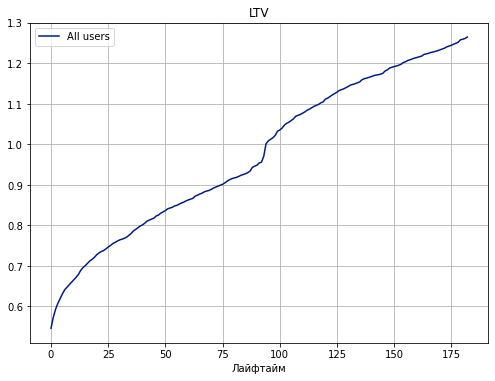

In [67]:
# кривая ltv
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2, 3, 1)
ltv_graf.T.plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('LTV')
plt.tight_layout()
plt.show()

Как и положено, LTV неуклонно растет с достаточно высоким стартом и резким подъемом на 99-ый день (7 сентября)

### 7.3 Визуализируем LTV за пол года жизни в динамики по когортам первого посещения

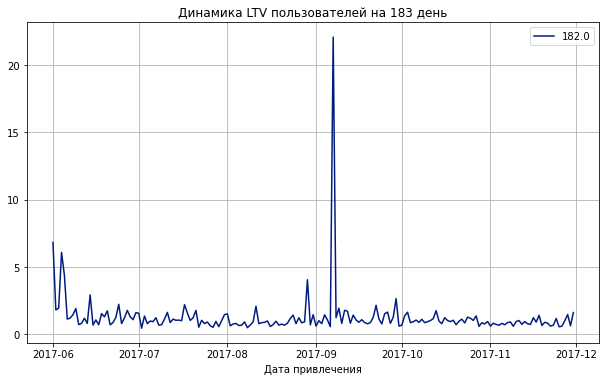

In [68]:
# динамика ltv
plt.figure(figsize=(25, 10))
ax2 = plt.subplot(2, 3, 2, sharey=ax1)
# столбцами сводной таблицы станут все столбцы индекса, кроме даты
columns = [name for name in ltv_history_graf.index.names if name not in ['dt']]
filtered_data = ltv_history_graf.pivot_table(
    index='dt', columns=columns, values=183 - 1, aggfunc='mean'
)
filtered_data.plot(grid=True, ax=ax2)
plt.xlabel('Дата привлечения')
plt.title('Динамика LTV пользователей на 183 день')
plt.tight_layout()
plt.show()

На графике видно, что когорта сентября имеет самый высокий показатель LTV за пол года жизни, в основном благодаря покупкам 7-ого сентября, где показатель LTV превысил 22 единицы.

In [69]:
September = [0.60909091,  1.01051913,  0.79260759,
        1.44464583,  1.06402174,  0.56457895, 22.0587193 ,  1.23527244,
        1.93969231,  0.80448549,  1.78546263,  1.71200864,  0.81841102,
        1.42419521,  1.06295413,  0.89268793,  1.08215596,  0.87053963,
        0.78223752,  0.86265165,  1.25174709,  2.15065041,  1.141875  ,
        0.76764706,  1.52193634,  1.64895095,  0.81405983,  1.25836943,
        2.64721535,  0.60848752,]
sum(September)

56.62787699000001

In [70]:
August = [1.51086817,  0.63038168,  0.76208333,  0.80781132,
        0.65132743,  0.67588235,  0.92264901,  0.48944251,  0.6898    ,
        0.92692958,  2.08396226,  0.78607143,  0.86430556,  0.88849003,
        0.98988669,  0.57634078,  0.72031609,  0.97134328,  0.67806867,
        0.75564202,  0.6773913 ,  0.8216095 ,  1.17950249,  1.42404432,
        0.79018767,  1.22328076,  0.85378299,  0.92204128,  4.04906178,
        0.69738938,  1.4550495]
sum(August)

31.474943160000002

In [71]:
July = [1.56308725,  0.45169675,  1.35582121,  0.78990123,  0.98393204,
        0.9373617 ,  1.23317757,  0.68080997,  0.70997368,  1.12819149,
        1.62532258,  0.87149338,  1.12743464,  1.03893525,  1.05353242,
        1.00903448,  2.19749453,  1.58066543,  1.03036058,  1.22326923,
        1.77507282,  0.52597826,  1.03953668,  0.79266667,  0.91171014,
        0.63222222,  0.51968927,  0.95642857,  0.5679668 ,  1.01478632,
        1.46621849,]
sum(July)

32.79377165

In [72]:
June = [ 6.82008264,  1.80702128,  1.94216545,  6.0768254 ,  4.36816354,
        1.12788873,  1.20006515,  1.45361111,  1.91281961,  0.71803333,
        0.80992188,  1.19060811,  0.80861176,  2.92161137,  0.68559184,
        1.06515152,  0.70962069,  1.53479839,  1.2959126 ,  1.7423822 ,
        0.70153846,  0.8755819 ,  1.25331522,  2.22612676,  0.79580838,
        1.21993521,  1.77474359,  1.30637744,  1.08698482,  1.60550409,]
sum(June)

53.03680247

In [73]:
October = [0.66981221,  1.37237079,  1.63756586,
        0.86945396,  0.92567308,  1.0563495 ,  0.88599311,  1.11289017,
        0.86573876,  0.92979218,  1.01911348,  1.162891  ,  1.75282609,
        0.98373874,  0.78589205,  1.23804726,  1.02009321,  0.94176396,
        1.04423501,  0.70642708,  0.96772304,  1.12326425,  0.84234694,
        1.2752194 ,  1.19043796,  1.02937186,  1.36473684,  0.59104167,
        0.85915194,  0.76825996,  0.94642295,]
sum(October)

31.93864431

In [74]:
November = [0.61282805,  0.81945946,
        0.7296328 ,  0.67341193,  0.81233244,  0.70769333,  0.86922807,
        0.91269555,  0.59307116,  0.9455375 ,  1.02232796,  0.73677143,
        0.94613982,  0.78053905,  0.73151292,  1.23163717,  0.90597092,
        1.4102521 ,  0.65129206,  0.89224359,  0.82314164,  0.60750853,
        0.67652041,  1.17340281,  0.55813993,  0.60438073,  1.00842473,
        1.46161081,  0.63575832,  1.61239861]
sum(November)

26.145863829999996

Данные таблицы ltv_history потвердили ожидания, показатели LTV в сентябре самые высокие и составляют практически четверть от суммарного показателя пользователей пришедших до декабря 2017 года.

## 8. Оценим распределение LTV по источнику привлечения и устройству

### 8.1 Получим таблицы LTV с параметром dimensions на источник

In [75]:
dimensions = ['source_id']
ltv_raw, ltv, ltv_history = get_ltv(
    profiles, df_orders, datetime(2017, 11, 30).date(), 183, dimensions=dimensions)

ltv_history.tail().reset_index()

,source_id,dt,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,...,173.0,174.0,175.0,176.0,177.0,178.0,179.0,180.0,181.0,182.0
0,10,2017-11-26,27,0.045185,0.045185,0.045185,0.045185,0.045185,0.045185,0.045185,...,0.144444,0.144444,0.144444,0.144444,0.144444,0.144444,0.144444,0.144444,0.144444,0.144444
1,10,2017-11-27,30,0.053000,0.053000,0.073333,0.073333,0.073333,0.073333,0.073333,...,0.073333,0.073333,0.073333,0.073333,0.073333,0.073333,0.073333,0.073333,0.073333,0.073333
2,10,2017-11-28,17,0.441765,0.441765,0.441765,0.441765,0.441765,0.441765,0.441765,...,0.657647,0.657647,0.657647,0.657647,0.657647,0.657647,0.657647,0.657647,0.657647,0.657647
3,10,2017-11-29,27,0.860370,1.086667,1.086667,1.086667,1.086667,1.086667,1.086667,...,1.199630,1.199630,1.199630,1.199630,1.199630,1.199630,1.199630,1.199630,1.199630,1.199630
4,10,2017-11-30,17,0.143529,0.147059,0.147059,0.147059,0.147059,0.147059,0.147059,...,0.290588,0.290588,0.290588,0.290588,0.290588,0.290588,0.290588,0.290588,0.290588,0.290588


### 8.2 Визуализируем LTV в соответствии с источником привлечения пользователей

In [76]:
# из таблицы ltv исключаем размеры когорт
ltv_source_id = ltv.drop(columns=['cohort_size'])
# в таблице динамики ltv оставляем только нужный лайфтайм
ltv_history_source_id = ltv_history.drop(columns=['cohort_size'])[[183 - 1]]

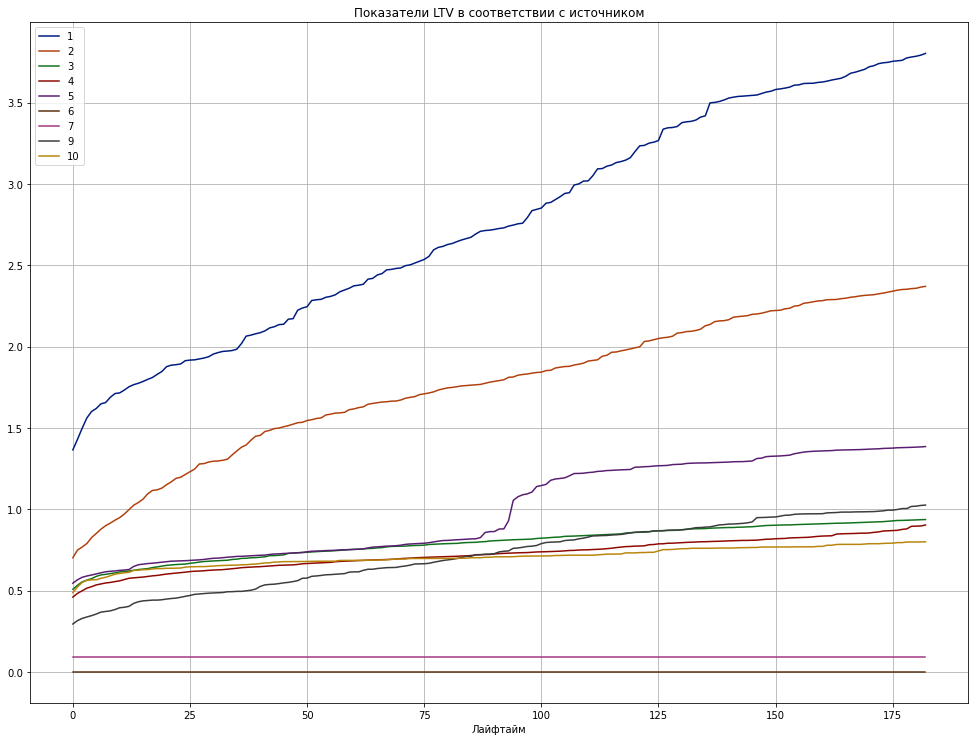

In [77]:
# кривая ltv по источникам
plt.figure(figsize=(40, 20))
ax1 = plt.subplot(2, 3, 1)
ltv_source_id.T.plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Показатели LTV в соответствии с источником')
plt.tight_layout()
plt.show()

Первый и второй канал лидируют, скачок LTV 7-ого сентября приходится на пользователей, кто пришел по 5 источнику. Остальные примерно на одном уровне.

### 8.3 Получим таблицы LTV, но уже с параметром dimensions на устройство

In [78]:
dimensions = ['device']
ltv_raw, ltv, ltv_history = get_ltv(
    profiles, df_orders, datetime(2017, 11, 30).date(), 183, dimensions=dimensions)

ltv_history.tail().reset_index()

,device,dt,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,...,173.0,174.0,175.0,176.0,177.0,178.0,179.0,180.0,181.0,182.0
0,touch,2017-11-26,280,0.195786,0.195786,0.231571,0.231571,0.231571,0.231571,0.231571,...,0.360929,0.360929,0.360929,0.360929,0.360929,0.360929,0.360929,0.360929,0.360929,0.360929
1,touch,2017-11-27,257,0.368872,0.383696,0.410078,0.410078,0.410078,0.410078,0.467160,...,0.706809,0.706809,0.706809,0.706809,0.706809,0.706809,0.706809,0.706809,0.706809,0.706809
2,touch,2017-11-28,222,0.146171,0.161486,0.183514,0.216532,0.224685,0.231577,0.231577,...,0.438288,0.438288,0.438288,0.438288,0.438288,0.438288,0.438288,0.438288,0.438288,0.438288
3,touch,2017-11-29,180,0.143556,0.149667,0.318722,0.318722,0.337556,0.367778,0.367778,...,0.475611,0.475611,0.475611,0.475611,0.475611,0.475611,0.475611,0.475611,0.475611,0.475611
4,touch,2017-11-30,210,0.216524,0.232667,0.232667,0.255952,0.261762,0.261762,0.261762,...,0.370619,0.370619,0.370619,0.370619,0.370619,0.370619,0.370619,0.370619,0.370619,0.370619


### 8.4 Визуализируем LTV в соответствии с устройством пользователя

In [79]:
# из таблицы ltv исключаем размеры когорт
ltv_source_id = ltv.drop(columns=['cohort_size'])
# в таблице динамики ltv оставляем только нужный лайфтайм
ltv_history_source_id = ltv_history.drop(columns=['cohort_size'])[[183 - 1]]

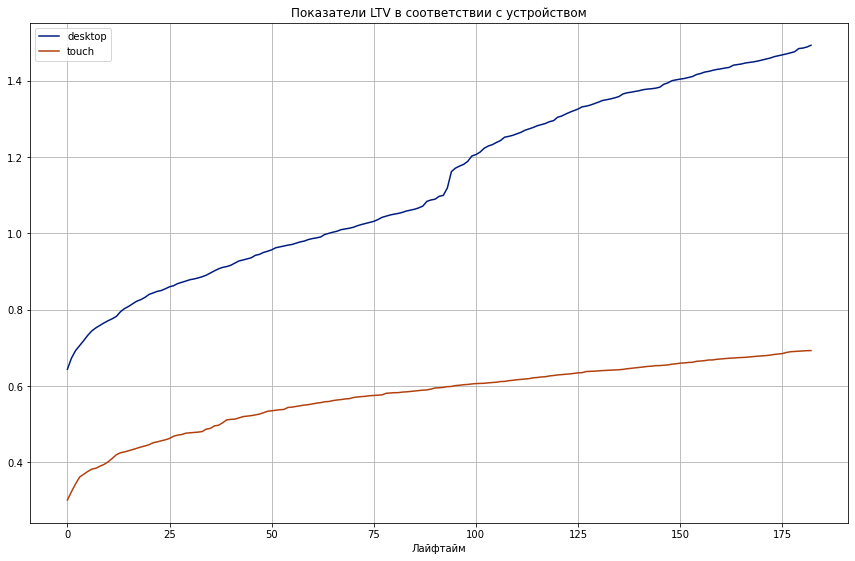

In [80]:
# кривая ltv по устройствам
plt.figure(figsize=(35, 15))
ax1 = plt.subplot(2, 3, 1)
ltv_source_id.T.plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Показатели LTV в соответствии с устройством')
plt.tight_layout()
plt.show()

Как и ожидалось лидерство за пользователями кто использует компьютер, от туда и клиенты 7-ого сентября

## 9. Вывод по проекту и рекомендации

Вывод:

При работе с датасетом были выполнены следующие действия.

Загрузили данные и предварительно с ними ознакомились. Провели предобработку данных, а именно:

Исправили заголовки столбцов и привели их к "хорошему" стилю. Изменили тип данных во всех трёх таблицах в столбцах с датами Проверили таблицы на наличие дубликатов (дубликатов нет)
Были заданы необходимые функции: связующая функция для создания пользовательских профилей и функция для расчета LTV

Больше всего средств было потрачено на 3-ий источник, почти в 2,5 раза больше чем на 4-ый, который занимает второе место. Далее идет 5-ый источник, траты на который составляют около 36% от 3-его.
На 9-ый и 10-ый источник потрачено примерно одинаковое количество средств, и на порядок меньше чем на другие.

Средний показатель LTV для пользователей пришедших до декабря 2017г. за пол года жизни составил 1.27

Исследовательский анализ показал, что самая высокая конверсия в покупателей у пользователей из 1-ого источника 30%.
У трех лидеров по количеству инвестиций большой приток пользователей в 7, 6 и 5 раз выше чем у 1-ого, но конверсия самая низкая 14.08-15.84 среди источников работающих на платной основе. Следом за 1-ым идет второй источник с конверсией в 20%.

Показатели LTV так же за 1-ым источником, чей уровень по прошествии пол года составил выше 3.5 единицы, далее покупатели из 2-ого источника, их показатель 2.4. Клиенты, чьи покупки 7-ого сентября стали аномальными, пришли по 5-ому источнику. Благодаря этому, показатели LTV достигли отметки в 1.4. Все остальные каналы показывают уровень LTV на полугодовой лайфтайм ниже среднего уровня.

Что касается устройств, то все показатели за пользователями использующими компьютер, клиенты 7-ого сентября так же относятся к этой категории.

Благодаря покупкам все того же 7-ого сентября, когорта пользователей, которые пришли впервые в этом месяце стала лидирующей. Без этой аномалии, уровень LTV был таким же как и в другие месяцы. Меньше всего покупок было произведено в ноябре. А в июне наблюдался пик покупок, отставания LTV от когорты сентября составило 5%. 

Рекомендации:

Источники привлечения 3 и 4 имеют самую высокую стоимость вложений, а показатели LTV одни из самых низких и ниже среднего LTV. Конверсия в покупателей так же ниже других источников. Следует распределить бюджет этих источников и направить его в 1 и 2, где самые высокие показатели LTV и конверсии, стоимость так же значительно ниже 3-его и 4-ого. 

Рекомендуется изучить аудиторию 5-ого источника и аномалию в покупках 7-ого сентября, Произвести сегментацию пользователей источников 3-4 и 1-2 с целью определения целевой аудитории. 

Зона целевой аудитории находится среди пользователей использующих для входа устройства desktop

Как и во многих других случаях стоит либо усиливать и менять ту структуру которая есть, или же искать новые пути решения в виде других рекламных источников. Я отдаю предпочтения усилению и изменению бюджета инвестирования в пользу каналов 1 и 2, по которым мы уже имеем статистику и можем предугадать дальнейшее поведение.

Так же стоит обратить внимание на такие показатели как CAC и ROI, которые могут внести дополнительную ясность в картину и степень окупаемости источников привлечения.